# Capstone Project: Can We Track Pro-Ukrainian Sentiment Through Tweets?

**Overview:** This project uses Natural Language Processing to classify tweets as Pro-Ukrainian following the Russian invasion of Uktraine, and then compares the performance of Classification models on a tweet dataset.

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
import re
import sys
import os
import nltk
import string
from textblob import TextBlob

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Chelly
[nltk_data]     Kearney\AppData\Roaming\nltk_data...


True

## Business Understanding

On February 24, 2022, Russia invaded Ukraine. This led to the largest refugee and humanitarian crisis within Europe since the Yugoslav Wars in the 1990s. According to a report by the [Council on Foreign Relations](https://www.cfr.org/article/how-much-aid-has-us-sent-ukraine-here-are-six-charts), forty-seven countries have provided military aid to Ukraine. The U.S. alone has directed more than \\$75 billion in assistance for humanitarian, financial, and military support. Ukraine expects a \\$38 billion budget deficit this year and the Ukrainian government is requesting an additional \$14 billion in foreign aid for rapid reconstruction of critical infrastructure [(Reuters).](https://www.reuters.com/world/europe/ukraine-says-its-received-167-bln-foreign-aid-this-year-2023-05-11/). Continued foreign aid is heavily dependent on public support for Ukraine. 

The goal of this project is to determine if we can track public sentiment for Ukraine through tweets.

## Data Understanding

The dataset used for this project comes from Daria Purtova on [Kaggle.](https://www.kaggle.com/datasets/foklacu/ukraine-war-tweets-dataset-65-days) Purtova compiled tweets between January 1, 2022 to March 6, 2022. She searched on the following phrases and compiled results into 8 separate CSV files based on the search phrases.

* ukraine war
* ukraine troops
* ukraine border
* ukraine NATO
* StandWithUkraine
* russian troops
* russian border ukraine
* russia invade

Each file consisted of 29 features. Some of the columns were identifiers, not unique, redundant or not populated enough to be useful. Nine of the features were useful for this study. They include the following:

* **Date** - the date the tweet was posted (object)
* **Content** - the text of the tweet (object)
* **replyCount** - the number of replies to the tweet (int64)
* **retweetCount** - the number of times the tweet was retweeted (int64)
* **likeCount** - the number of times the tweet was liked (int64)
* **quoteCount** - the number of times the tweet was quoted (int64)
* **SourceLabel** - the type of app from which the tweet was sent (e.g. iPhone, Android, Web app) (object)
* **hashtags** - hashtags included in the text
* **Searh** - the search phrase used to compile the text

The language of the text was one of the features, but only English texts were used for this study. Only texts that included hashtags were used for this study. To save on computational time, 7000 tweets were randomnly selected from each of the 8 CSV files to make the final dataset.

## Data Preparation

To save on computational time - clean each file separately and reduce. Then combine files to build dataset.

### First File: 'StandWithUkraine' dataset

In [145]:
swu = pd.read_csv('data/StandWithUkraine.csv')

##### Select only English tweets

In [146]:
swu_en = swu[swu['lang']=='en']
swu_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87819 entries, 0 to 148144
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _type             87819 non-null  object 
 1   url               87819 non-null  object 
 2   date              87819 non-null  object 
 3   content           87819 non-null  object 
 4   renderedContent   87819 non-null  object 
 5   id                87819 non-null  int64  
 6   user              87819 non-null  object 
 7   replyCount        87819 non-null  int64  
 8   retweetCount      87819 non-null  int64  
 9   likeCount         87819 non-null  int64  
 10  quoteCount        87819 non-null  int64  
 11  conversationId    87819 non-null  int64  
 12  lang              87819 non-null  object 
 13  source            87819 non-null  object 
 14  sourceUrl         87819 non-null  object 
 15  sourceLabel       87819 non-null  object 
 16  outlinks          34642 non-null  objec

##### Remove non-applicable columns
Some columns have redundant information (SourceURL and SourceLabel). Some have so few entries as to be useful. Some columns are not unique to a tweet (type).

In [147]:
swu_col = swu_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
swu_col.shape

(87819, 9)

##### Remove tweets with null values

In [148]:
swu_col.isnull().sum().sort_values()

date                0
content             0
replyCount          0
retweetCount        0
likeCount           0
quoteCount          0
sourceLabel         0
Searh               0
hashtags        18237
dtype: int64

In [149]:
swu_data = swu_col.dropna(subset = ['hashtags'])
swu_data.shape

(69582, 9)

##### Remove duplicates

In [150]:
swu_data.drop_duplicates(keep='first', inplace=True)
swu_data.shape

(69581, 9)

##### Reduce the dataset to minimize computation time

In [151]:
swu_final = swu_data.sample(n=7000, replace=False, random_state=42)
swu_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 25804 to 72031
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Second File: 'Russia_invade' dataset

In [152]:
ri = pd.read_csv('data/Russia_invade.csv')

##### Select only English tweets

In [153]:
ri_en = ri[ri['lang']=='en']
ri_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165649 entries, 0 to 170834
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             165649 non-null  object 
 1   url               165649 non-null  object 
 2   date              165649 non-null  object 
 3   content           165649 non-null  object 
 4   renderedContent   165649 non-null  object 
 5   id                165649 non-null  int64  
 6   user              165649 non-null  object 
 7   replyCount        165649 non-null  int64  
 8   retweetCount      165649 non-null  int64  
 9   likeCount         165649 non-null  int64  
 10  quoteCount        165649 non-null  int64  
 11  conversationId    165649 non-null  int64  
 12  lang              165649 non-null  object 
 13  source            165649 non-null  object 
 14  sourceUrl         165649 non-null  object 
 15  sourceLabel       165649 non-null  object 
 16  outlinks          37

##### Remove non-applicable columns

In [154]:
ri_col = ri_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
ri_col.shape

(165649, 9)

##### Remove tweets with null values

In [155]:
ri_col.isnull().sum().sort_values()

date                 0
content              0
replyCount           0
retweetCount         0
likeCount            0
quoteCount           0
sourceLabel          0
Searh                0
hashtags        147260
dtype: int64

In [156]:
ri_data = ri_col.dropna(subset = ['hashtags'])
ri_data.shape

(18389, 9)

##### Remove duplicates

In [157]:
ri_data.drop_duplicates(keep='first', inplace=True)
ri_data.shape

(18389, 9)

##### Reduce dataset to minimize computational time

In [158]:
ri_final = ri_data.sample(n=7000, replace=False, random_state=42)
ri_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 166767 to 8829
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Third File: 'Russia_border_Ukraine' dataset

In [159]:
rbu = pd.read_csv('data/Russian_border_Ukraine.csv')

##### Select only English tweets

In [160]:
rbu_en = rbu[rbu['lang']=='en']
rbu_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52616 entries, 0 to 53039
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _type             52616 non-null  object 
 1   url               52616 non-null  object 
 2   date              52616 non-null  object 
 3   content           52616 non-null  object 
 4   renderedContent   52616 non-null  object 
 5   id                52616 non-null  int64  
 6   user              52616 non-null  object 
 7   replyCount        52616 non-null  int64  
 8   retweetCount      52616 non-null  int64  
 9   likeCount         52616 non-null  int64  
 10  quoteCount        52616 non-null  int64  
 11  conversationId    52616 non-null  int64  
 12  lang              52616 non-null  object 
 13  source            52616 non-null  object 
 14  sourceUrl         52616 non-null  object 
 15  sourceLabel       52616 non-null  object 
 16  outlinks          17148 non-null  object

##### Remove non-applicable columns

In [161]:
rbu_col = rbu_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
rbu_col.shape

(52616, 9)

##### Remove tweets with null values

In [162]:
rbu_col.isnull().sum().sort_values()

date                0
content             0
replyCount          0
retweetCount        0
likeCount           0
quoteCount          0
sourceLabel         0
Searh               0
hashtags        41360
dtype: int64

In [163]:
rbu_data = rbu_col.dropna(subset = ['hashtags'])
rbu_data.shape

(11256, 9)

##### Remove duplicates

In [164]:
rbu_data.drop_duplicates(keep='first', inplace=True)
rbu_data.shape

(11256, 9)

##### Reduce dataset size

In [165]:
rbu_final = rbu_data.sample(n=7000, replace=False, random_state=42)
rbu_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 10490 to 38557
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Fourth File: 'Russian_troops' dataset

In [166]:
rt = pd.read_csv('data/Russian_troops.csv')

##### Select only English tweets

In [167]:
rt_en = rt[rt['lang']=='en']
rt_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126962 entries, 0 to 128404
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             126962 non-null  object 
 1   url               126962 non-null  object 
 2   date              126962 non-null  object 
 3   content           126962 non-null  object 
 4   renderedContent   126962 non-null  object 
 5   id                126962 non-null  int64  
 6   user              126962 non-null  object 
 7   replyCount        126962 non-null  int64  
 8   retweetCount      126962 non-null  int64  
 9   likeCount         126962 non-null  int64  
 10  quoteCount        126962 non-null  int64  
 11  conversationId    126962 non-null  int64  
 12  lang              126962 non-null  object 
 13  source            126962 non-null  object 
 14  sourceUrl         126962 non-null  object 
 15  sourceLabel       126962 non-null  object 
 16  outlinks          46

##### Remove non-applicable columns

In [168]:
rt_col = rt_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
rt_col.shape

(126962, 9)

##### Remove tweets with null values

In [169]:
rt_col.isnull().sum().sort_values()

date                 0
content              0
replyCount           0
retweetCount         0
likeCount            0
quoteCount           0
sourceLabel          0
Searh                0
hashtags        105841
dtype: int64

In [170]:
rt_data = rt_col.dropna(subset = ['hashtags'])
rt_data.shape

(21121, 9)

##### Remove duplicates

In [171]:
rt_data.drop_duplicates(keep='first',inplace=True)
rt_data.shape

(21119, 9)

##### Minimize dataset size

In [172]:
rt_final = rt_data.sample(n=7000, replace=False,random_state=42)
rt_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 39817 to 67389
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Fifth File: 'Ukraine_border' dataset

In [173]:
ub = pd.read_csv('data/Ukraine_border.csv')

##### Select only English tweets

In [174]:
ub_en = ub[ub['lang']=='en']
ub_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164732 entries, 0 to 166609
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             164732 non-null  object 
 1   url               164732 non-null  object 
 2   date              164732 non-null  object 
 3   content           164732 non-null  object 
 4   renderedContent   164732 non-null  object 
 5   id                164732 non-null  int64  
 6   user              164732 non-null  object 
 7   replyCount        164732 non-null  int64  
 8   retweetCount      164732 non-null  int64  
 9   likeCount         164732 non-null  int64  
 10  quoteCount        164732 non-null  int64  
 11  conversationId    164732 non-null  int64  
 12  lang              164732 non-null  object 
 13  source            164732 non-null  object 
 14  sourceUrl         164732 non-null  object 
 15  sourceLabel       164732 non-null  object 
 16  outlinks          54

##### Remove non-applicable columns

In [175]:
ub_col = ub_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
ub_col.shape

(164732, 9)

##### Remove tweets with null values

In [176]:
ub_col.isnull().sum().sort_values()

date                 0
content              0
replyCount           0
retweetCount         0
likeCount            0
quoteCount           0
sourceLabel          0
Searh                0
hashtags        134171
dtype: int64

In [177]:
ub_data = ub_col.dropna(subset=['hashtags'])
ub_data.shape

(30561, 9)

##### Drop duplicates

In [178]:
ub_data.drop_duplicates(keep='first',inplace=True)
ub_data.shape

(29900, 9)

##### Minimize dataset size

In [179]:
ub_final = ub_data.sample(n=7000, replace=False, random_state=42)
ub_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 80034 to 136353
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Sixth File: 'Ukraine_nato' dataset

In [180]:
un = pd.read_csv('data/Ukraine_nato.csv')

##### Select only English tweets

In [181]:
un_en = un[un['lang']=='en']
un_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217862 entries, 0 to 245231
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             217862 non-null  object 
 1   url               217862 non-null  object 
 2   date              217862 non-null  object 
 3   content           217862 non-null  object 
 4   renderedContent   217862 non-null  object 
 5   id                217862 non-null  int64  
 6   user              217862 non-null  object 
 7   replyCount        217862 non-null  int64  
 8   retweetCount      217862 non-null  int64  
 9   likeCount         217862 non-null  int64  
 10  quoteCount        217862 non-null  int64  
 11  conversationId    217862 non-null  int64  
 12  lang              217862 non-null  object 
 13  source            217862 non-null  object 
 14  sourceUrl         217862 non-null  object 
 15  sourceLabel       217862 non-null  object 
 16  outlinks          62

##### Remove non-applicable columns

In [182]:
un_col = un_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
un_col.shape

(217862, 9)

##### Remove tweets with null values

In [183]:
un_col.isnull().sum()

date                 0
content              0
replyCount           0
retweetCount         0
likeCount            0
quoteCount           0
sourceLabel          0
hashtags        177728
Searh                0
dtype: int64

In [184]:
un_data = un_col.dropna(subset=['hashtags'])
un_data.shape

(40134, 9)

##### Drop duplicates

In [185]:
un_data.drop_duplicates(keep='first',inplace=True)
un_data.shape

(40134, 9)

##### Minimize dataset size

In [186]:
un_final = un_data.sample(n=7000, replace='False',random_state=42)
un_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 98072 to 52428
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Seventh File: 'Ukraine_troops' dataset

In [187]:
ut = pd.read_csv('data/Ukraine_troops.csv')

##### Select only English tweets

In [188]:
ut_en = ut[ut['lang']=='en']
ut_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171479 entries, 0 to 172713
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             171479 non-null  object 
 1   url               171479 non-null  object 
 2   date              171479 non-null  object 
 3   content           171479 non-null  object 
 4   renderedContent   171479 non-null  object 
 5   id                171479 non-null  int64  
 6   user              171479 non-null  object 
 7   replyCount        171479 non-null  int64  
 8   retweetCount      171479 non-null  int64  
 9   likeCount         171479 non-null  int64  
 10  quoteCount        171479 non-null  int64  
 11  conversationId    171479 non-null  int64  
 12  lang              171479 non-null  object 
 13  source            171479 non-null  object 
 14  sourceUrl         171479 non-null  object 
 15  sourceLabel       171479 non-null  object 
 16  outlinks          66

##### Remove non-applicable columns

In [189]:
ut_col = ut_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
ut_col.shape

(171479, 9)

##### Remove tweets with null values

In [190]:
ut_col.isnull().sum()

date                 0
content              0
replyCount           0
retweetCount         0
likeCount            0
quoteCount           0
sourceLabel          0
hashtags        141025
Searh                0
dtype: int64

In [191]:
ut_data = ut_col.dropna(subset=['hashtags'])
ut_data.shape

(30454, 9)

##### Drop duplicates

In [192]:
ut_data.drop_duplicates(keep='first',inplace=True)
ut_data.shape

(30452, 9)

##### Minimize dataset size

In [193]:
ut_final = ut_data.sample(n=7000, replace=False, random_state=42)
ut_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 167716 to 14589
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Eight File: 'Ukraine_war' dataset

In [194]:
uw = pd.read_csv('data/Ukraine_war.csv')

##### Select only English tweets

In [196]:
uw_en = uw[uw['lang']=='en']
uw_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219866 entries, 0 to 231623
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             219866 non-null  object 
 1   url               219866 non-null  object 
 2   date              219866 non-null  object 
 3   content           219866 non-null  object 
 4   renderedContent   219866 non-null  object 
 5   id                219866 non-null  int64  
 6   user              219866 non-null  object 
 7   replyCount        219866 non-null  int64  
 8   retweetCount      219866 non-null  int64  
 9   likeCount         219866 non-null  int64  
 10  quoteCount        219866 non-null  int64  
 11  conversationId    219866 non-null  int64  
 12  lang              219866 non-null  object 
 13  source            219866 non-null  object 
 14  sourceUrl         219866 non-null  object 
 15  sourceLabel       219866 non-null  object 
 16  outlinks          72

##### Remove non-applicable columns

In [197]:
uw_col = uw_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'hashtags','Searh']]
uw_col.shape

(219866, 9)

##### Remove tweets with null values

In [198]:
uw_col.isnull().sum()

date                 0
content              0
replyCount           0
retweetCount         0
likeCount            0
quoteCount           0
sourceLabel          0
hashtags        180041
Searh                0
dtype: int64

In [199]:
uw_data = uw_col.dropna(subset = ['hashtags'])
uw_data.shape

(39825, 9)

##### Drop duplicates

In [200]:
uw_data.drop_duplicates(keep='first',inplace=True)
uw_data.shape

(39825, 9)

##### Minimize dataset size

In [201]:
uw_final = uw_data.sample(n=7000, replace=False, random_state=42)
uw_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 160532 to 68304
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   hashtags      7000 non-null   object
 8   Searh         7000 non-null   object
dtypes: int64(4), object(5)
memory usage: 546.9+ KB


### Build the dataset by combining the eight files

In [202]:
files = [swu_final, ri_final, rbu_final, rt_final, ub_final, un_final, ut_final, uw_final]
data = pd.concat(files)
data.shape

(56000, 9)

### Remove time portion from the date-time column

In [75]:
data['date'] = data.date.str.slice(0,10)
data['date'].unique()

array(['2022-03-03', '2022-03-05', '2022-03-04', '2022-02-22',
       '2022-02-08', '2022-02-17', '2022-03-02', '2022-02-26',
       '2022-02-20', '2022-02-28', '2022-02-21', '2022-02-27',
       '2022-01-24', '2022-02-23', '2022-01-26', '2022-03-01',
       '2022-01-22', '2022-02-24', '2022-01-23', '2022-02-25',
       '2022-01-28', '2022-01-25', '2022-02-13', '2022-02-16',
       '2022-01-19', '2022-02-14', '2022-02-18', '2022-02-05',
       '2022-02-12', '2022-01-27', '2022-02-15', '2022-02-02',
       '2022-02-19', '2022-01-29', '2022-02-03', '2022-02-07',
       '2022-02-09', '2022-02-10', '2022-01-31', '2022-02-01',
       '2022-01-30', '2022-02-11', '2022-02-04', '2022-01-07',
       '2022-02-06', '2022-01-21', '2022-01-14', '2022-01-20',
       '2022-01-15', '2022-01-17', '2022-01-13', '2022-01-11',
       '2021-12-31', '2022-01-18', '2022-01-12', '2022-01-10',
       '2022-01-05', '2022-01-02', '2022-01-04', '2022-01-08',
       '2022-01-16', '2022-01-09', '2022-01-03', '2022-

### Create features using Sentiment Analysis
(Note this method follows [satyajit1910](https://www.geeksforgeeks.org/twitter-sentiment-analysis-on-russia-ukraine-war-using-python/))

##### Remove RT, punctuation, etc from tweet

In [76]:
# Examine tweets before cleaning
data['content'][0:10]

25804     Standing in front of the Senate House, to #Sta...
7747      @elingenieritu Putin is Trump's idol. @Russia ...
19173     @ragipsoylu It’s just like, your people are ki...
113401    What a sad day. I’m with Ukraine. I stand with...
138047    Now, from 🇺🇦 SHMURATKO.\n\nSuperb airy jumps, ...
129237    Good to stand with #Ukraine MPs 🇺🇦 @lesiavasyl...
30733     Statement by K2 Integrity Co-CEOs Jeremy Kroll...
71996     26/02/2022 #StandWithUkraine *verified* https:...
34923     The situation in Kyiv shows why second amendme...
121840    #StandWithUkraine prayers with you all. The Ru...
Name: content, dtype: object

In [209]:
def remove_rt(x): return re.sub('RT @\w+: ', " ", x)
 
def rt(x): return re.sub(
    "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x)

data["content"] = data.content.map(remove_rt).map(rt)
data["content"] = data.content.str.lower()

In [210]:
# Examine tweets after cleaning
data['content'][0:10]

25804     standing in front of the senate house  to  sta...
7747        putin is trump s idol    need to overthrow h...
19173       it s just like  your people are killed  none...
113401    what a sad day  i m with ukraine  i stand with...
138047    now  from    shmuratko   superb airy jumps  wi...
129237    good to stand with  ukraine mps      and   shk...
30733     statement by k2 integrity co ceos jeremy kroll...
71996             26 02 2022  standwithukraine  verified   
34923     the situation in kyiv shows why second amendme...
121840     standwithukraine prayers with you all  the ru...
Name: content, dtype: object

##### Perform Sentiment Analysis using TextBlob library - add feature column classifying each tweet by 'sentiment'

In [211]:
data[['polarity', 'subjectivity']] = data['content'].apply(
    lambda Text: pd.Series(TextBlob(Text).sentiment))
 
for index, row in data['content'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
     
    if pos > neg:
        data.loc[index, 'sentiment'] = "positive"
    else:
        data.loc[index, 'sentiment'] = "negative"
         
    data.loc[index, 'neg'] = neg
    data.loc[index, 'neu'] = neu
    data.loc[index, 'pos'] = pos
    data.loc[index, 'compound'] = comp

data[["content", "sentiment", "polarity","subjectivity", "neg", "neu", "pos"]].head(5)  

,content,sentiment,polarity,subjectivity,neg,neu,pos
25804,standing in front of the senate house to sta...,negative,0.000000,0.000000,0.000,1.000,0.000
7747,putin is trump s idol need to overthrow h...,negative,0.000000,0.000000,0.000,1.000,0.000
19173,it s just like your people are killed none...,negative,-0.140000,0.473333,0.124,0.779,0.096
113401,what a sad day i m with ukraine i stand with...,negative,-0.500000,1.000000,0.279,0.721,0.000
138047,now from shmuratko superb airy jumps wi...,positive,0.833333,0.883333,0.000,0.582,0.418


##### Visualize the Results

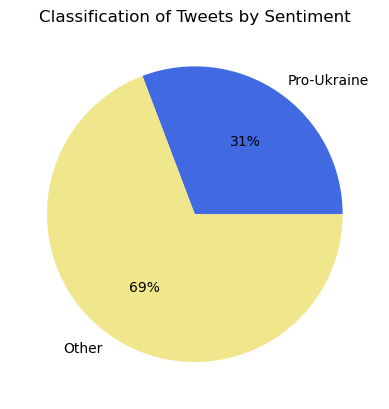

<Figure size 640x480 with 0 Axes>

In [212]:
total_pos = len(data.loc[data['sentiment']=='positive'])
total_neg = len(data.loc[data['sentiment']=='negative'])
total_tweets = len(data)
pie_data = [total_pos/total_tweets, total_neg/total_tweets]
keys = ['Pro-Ukraine', 'Other']
mycolors = ['royalblue','khaki']
plt.pie(pie_data, labels=keys, colors=mycolors, autopct='%.0f%%')
plt.title('Classification of Tweets by Sentiment')
plt.show()
plt.savefig('images/pie_tweets');

In [95]:
data['Searh'].unique()

array(['StandWithUkraine', 'Russia invade', 'Russian border Ukraine',
       'Russian troops', 'Ukraine border', 'Ukraine NATO',
       'Ukraine troops', 'Ukraine war'], dtype=object)

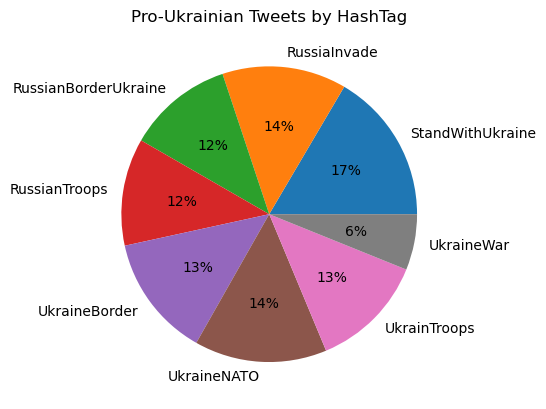

In [100]:
pos_sent = data[data['sentiment']=='positive']
total_sent = len(pos_sent)
swu_pos = len(pos_sent.loc[pos_sent['Searh']=='StandWithUkraine'])
ri_pos = len(pos_sent.loc[pos_sent['Searh']=='Russia invade'])
rbu_pos = len(pos_sent.loc[pos_sent['Searh']=='Russian border Ukraine'])
rt_pos = len(pos_sent.loc[pos_sent['Searh']=='Russian troops'])
ub_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine border'])
un_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine NATO'])
ut_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine troops'])
uw_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine war'])
pie_data2 = [swu_pos/total_sent, ri_pos/total_sent, rbu_pos/total_sent, rt_pos/total_sent, ub_pos/total_sent,
            un_pos/total_sent, ut_pos/total_sent, uw_pos/total_sent]

keys = ['StandWithUkraine', 'RussiaInvade', 'RussianBorderUkraine', 'RussianTroops', 'UkraineBorder','UkraineNATO',
       'UkrainTroops','UkraineWar']
plt.pie(pie_data2, labels=keys, autopct='%.0f%%')
plt.title('Pro-Ukrainian Tweets by HashTag')
plt.show()

### Explore other features

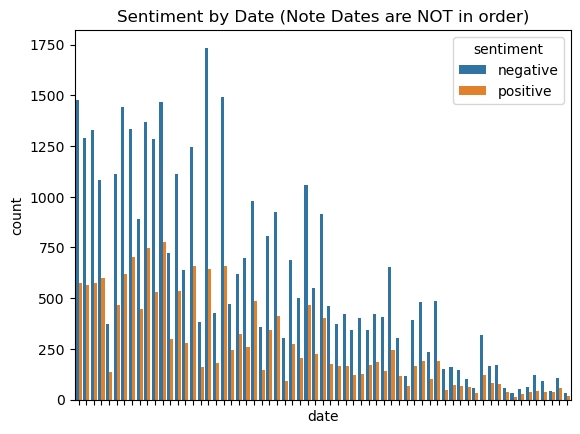

In [111]:
# date
sns.countplot(x = 'date', data=data, hue='sentiment')
plt.xticks(visible=False)
plt.title('Sentiment by Date (Note Dates are NOT in order)')
plt.show()

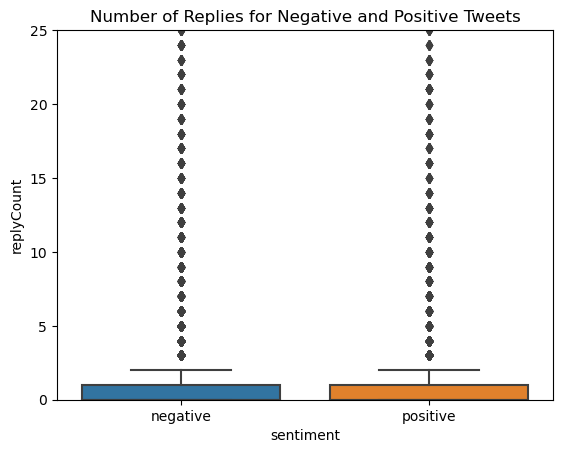

In [116]:
# reply count
sns.boxplot(x='sentiment', y='replyCount', data=data)
plt.ylim(0,25)
plt.title('Number of Replies for Negative and Positive Tweets');

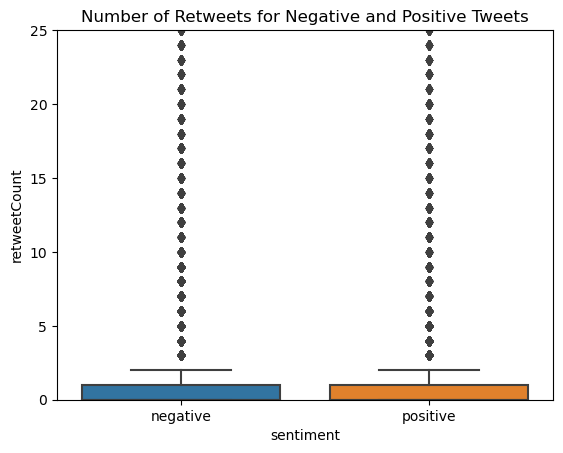

In [117]:
# retweet count
sns.boxplot(x='sentiment', y='retweetCount', data=data)
plt.ylim(0,25)
plt.title('Number of Retweets for Negative and Positive Tweets');

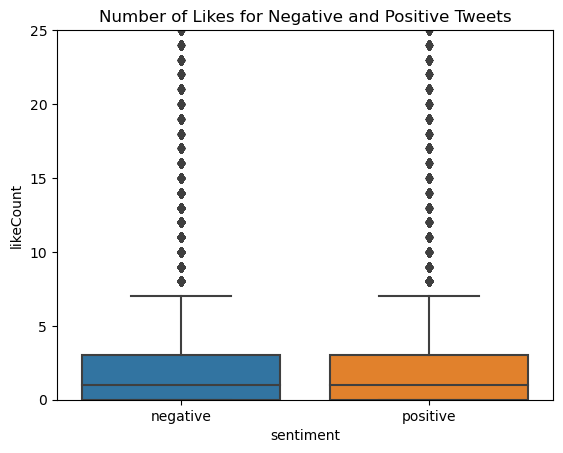

In [118]:
# like count
sns.boxplot(x='sentiment', y='likeCount', data=data)
plt.ylim(0,25)
plt.title('Number of Likes for Negative and Positive Tweets');

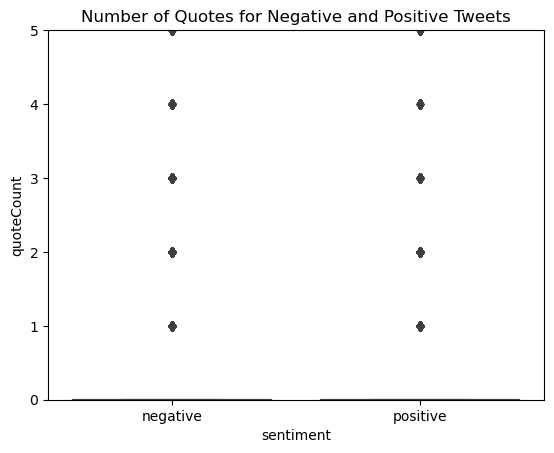

In [120]:
# quote count
sns.boxplot(x='sentiment', y='quoteCount', data=data)
plt.ylim(0,5)
plt.title('Number of Quotes for Negative and Positive Tweets');

In [122]:
# SourceLabel
data['sourceLabel'].value_counts()

Twitter Web App              20794
Twitter for iPhone           13416
Twitter for Android          12924
Twitter for iPad              1510
TweetDeck                     1447
                             ...  
Hypefury                         1
Denim Social - Publishing        1
ETFWorld.co.uk                   1
StockSwapApp                     1
omgoa                            1
Name: sourceLabel, Length: 417, dtype: int64

In [123]:
# elminate tweets with only 1 unique value
list = ['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android', 'Twitter for iPad', 'TweetDeck']
data_pp = data[data['sourceLabel'].isin(list)]
data_pp['sourceLabel'].value_counts()

Twitter Web App        20794
Twitter for iPhone     13416
Twitter for Android    12924
Twitter for iPad        1510
TweetDeck               1447
Name: sourceLabel, dtype: int64

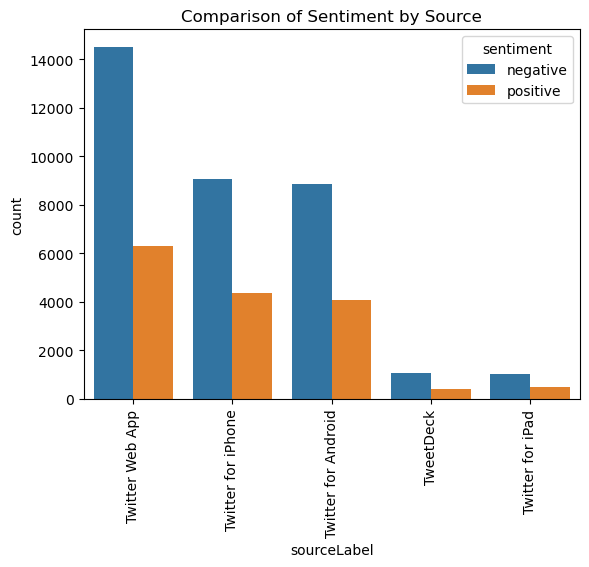

In [127]:
sns.countplot(x='sourceLabel', data=data_pp, hue = 'sentiment')
plt.xticks(rotation=90)
plt.title('Comparison of Sentiment by Source');

##### Need to deal with hashtag feature but need to apply an NLP model

## Modeling

### Build training and test sets
* Eliminate hashtag - still needs preprocessing
* Elminate quoteCount - zero for both sentiments, useless

In [128]:
X = data_pp[['date','replyCount','retweetCount', 'likeCount', 'sourceLabel', 'Searh']]
y = data_pp['sentiment']

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, stratify=y)

### Build a Baseline Model

In [130]:
y_test.value_counts(normalize=True)

negative    0.688333
positive    0.311667
Name: sentiment, dtype: float64

### Make a Column Transformer

In [131]:
# Convert oject columns to a numeric value
# Scale the numeric column
selector = make_column_selector(dtype_include=object)    # Select the object categories
transformer = make_column_transformer((OneHotEncoder(),selector), remainder=StandardScaler())

### Classification Model Using Logistic Regression

In [133]:
lr_pipe = Pipeline([
    ('transform', transformer),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_train,y_train)

In [134]:
lr_train_acc = lr_pipe.score(X_train,y_train)
lr_test_acc = lr_pipe.score(X_test,y_test)
print(lr_train_acc,lr_test_acc)

0.6883251703577513 0.6880939072107323


In [139]:
extractor = SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',random_state=42))
lr_pipe = Pipeline([
    ('transform', transformer),
    ('extractor', extractor),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_train,y_train)
feature_names = lr_pipe.named_steps['transform'].get_feature_names_out() 
selected_features =feature_names[ [int(i[1:]) for i in lr_pipe.named_steps['extractor'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lr_pipe.named_steps['lr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df[0:10]

,feature,coefs
68,Searh_Ukraine war,1.057207
2,date_2022-01-05,0.509284
31,date_2022-02-05,0.489166
0,date_2021-12-31,0.411564
1,date_2022-01-03,0.406030
3,date_2022-01-06,0.395772
8,date_2022-01-11,0.348758
65,Searh_StandWithUkraine,0.292974
9,date_2022-01-12,0.279454
15,date_2022-01-18,0.273146


### Classification Model using K-Nearest Neighbors

In [137]:
knn_params = {'knn__n_neighbors':np.array(range(1,10,5))}

knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier())
])

import warnings
warnings.filterwarnings('ignore')
knn_grid = GridSearchCV(knn_pipe,param_grid = knn_params).fit(X_train,y_train)
knn_grid.best_params_

{'knn__n_neighbors': 6}

In [141]:
# Run the model with optimum k value
knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier(n_neighbors=6))
]).fit(X_train,y_train)

In [142]:
knn_train_preds = knn_pipe.predict(X_train)
knn_train_acc = accuracy_score(y_train,knn_train_preds)
knn_test_preds = knn_pipe.predict(X_test)
knn_test_acc = accuracy_score(y_test,knn_test_preds)
print(knn_train_acc,knn_test_acc)

0.7178715928449745 0.6676515212009901


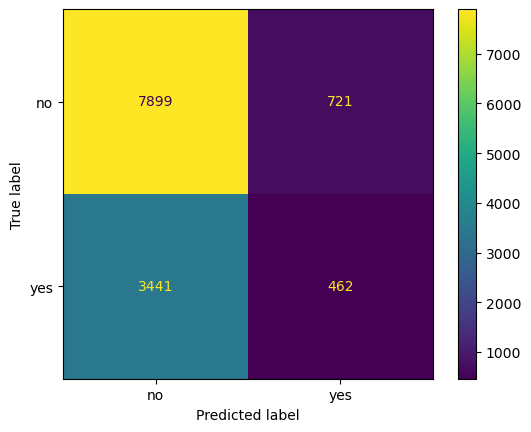

In [143]:
knn_confusion_mat  = confusion_matrix(y_test, knn_test_preds, labels=knn_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

### Classification Model using Decision Trees

In [203]:
dt_pipe = Pipeline([
    ('transform', transformer),
    ('dt', DecisionTreeClassifier())
])
dt_params = {'dt__max_depth': ['None', 3,8,12]}
dt_grid = GridSearchCV(dt_pipe,param_grid=dt_params).fit(X_train,y_train)
dt_grid.best_params_

{'dt__max_depth': 3}

In [205]:
# Run the model using optimum max_depth
dt_pipe = Pipeline([
    ('transform', transformer),
    ('dt', DecisionTreeClassifier(max_depth = 3))
]).fit(X_train,y_train)

In [206]:
dt_train_acc = dt_pipe.score(X_train,y_train)
dt_test_acc = dt_pipe.score(X_test,y_test)
print(dt_train_acc,dt_test_acc)

0.6882985519591142 0.688333466421784


## Evaluation

##### Build a Table to Compare Model Results

In [207]:
Model=['Logistic Regression','K-Nearest Neighbors','Decision Tree'] #,'Support Vector Machine']
Train = [lr_train_acc,knn_train_acc,dt_train_acc] #,svc_train_acc]
Test = [lr_test_acc,knn_test_acc,dt_test_acc] #,svc_test_acc]
#Prec = [lr_test_pre,knn_test_pre,dt_test_pre,svc_test_pre]
#Rec = [lr_test_rec,knn_test_rec,dt_test_rec,svc_test_rec]
Results = pd.DataFrame({'Model':Model,'Train Accuracy':Train,'Test Accuracy':Test}) #, 'Test Precision':Prec, 'Test Recall':Rec})
Results.set_index('Model')

,Train Accuracy,Test Accuracy
Model,,
Logistic Regression,0.688325,0.688094
K-Nearest Neighbors,0.717872,0.667652
Decision Tree,0.688299,0.688333


## Deployment

These are preliminary results. If we can build a successful model, we could scrape tweets and run through our model to track sentiment for a given time period.